```bash
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m ragen.llm_agent.agent_proxy \
  es_manager.val.env_groups=256 \
  es_manager.val.group_size=16 \
  es_manager.val.env_configs.n_groups=[256] \
  es_manager.val.env_configs.tags=["CoordSokoban"] \
  output.dir=results/eval/sokoban \
  system.CUDA_VISIBLE_DEVICES=\"0,1,2,3\" \
  actor_rollout_ref.rollout.tensor_model_parallel_size=4

CUDA_VISIBLE_DEVICES=4,5,6,7 python -m ragen.llm_agent.agent_proxy \
  es_manager.val.env_groups=256 \
  es_manager.val.group_size=16 \
  es_manager.val.env_configs.n_groups=[256] \
  es_manager.val.env_configs.tags=["CoordFrozenLake"] \
  output.dir=results/eval/frozenlake \
  system.CUDA_VISIBLE_DEVICES=\"4,5,6,7\" \
  actor_rollout_ref.rollout.tensor_model_parallel_size=4

CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7 python -m ragen.llm_agent.agent_proxy \
  es_manager.val.env_groups=256 \
  es_manager.val.group_size=16 \
  es_manager.val.env_configs.n_groups=[256] \
  es_manager.val.env_configs.tags=["Bandit"] \
  output.dir=results/eval/bandit \
  system.CUDA_VISIBLE_DEVICES=\"0,1,2,3,4,5,6,7\" \
  actor_rollout_ref.rollout.tensor_model_parallel_size=8 \
  agent_proxy.max_turn=1 \
  agent_proxy.max_actions_per_turn=1

CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7 python -m ragen.llm_agent.agent_proxy \
  es_manager.val.env_groups=256 \
  es_manager.val.group_size=16 \
  es_manager.val.env_configs.n_groups=[256] \
  es_manager.val.env_configs.tags=["WebShop"] \
  output.dir=results/eval/webshop \
  system.CUDA_VISIBLE_DEVICES=\"0,1,2,3,4,5,6,7\" \
  actor_rollout_ref.rollout.tensor_model_parallel_size=8 \
  actor_rollout_ref.rollout.max_model_len=15000 \
  actor_rollout_ref.rollout.max_num_batched_tokens=15000 \
  agent_proxy.max_turn=9 \
  agent_proxy.max_actions_per_turn=1


```


In [36]:
data.non_tensor_batch['n_turns']

array([5., 3., 5., ..., 5., 5., 1.])

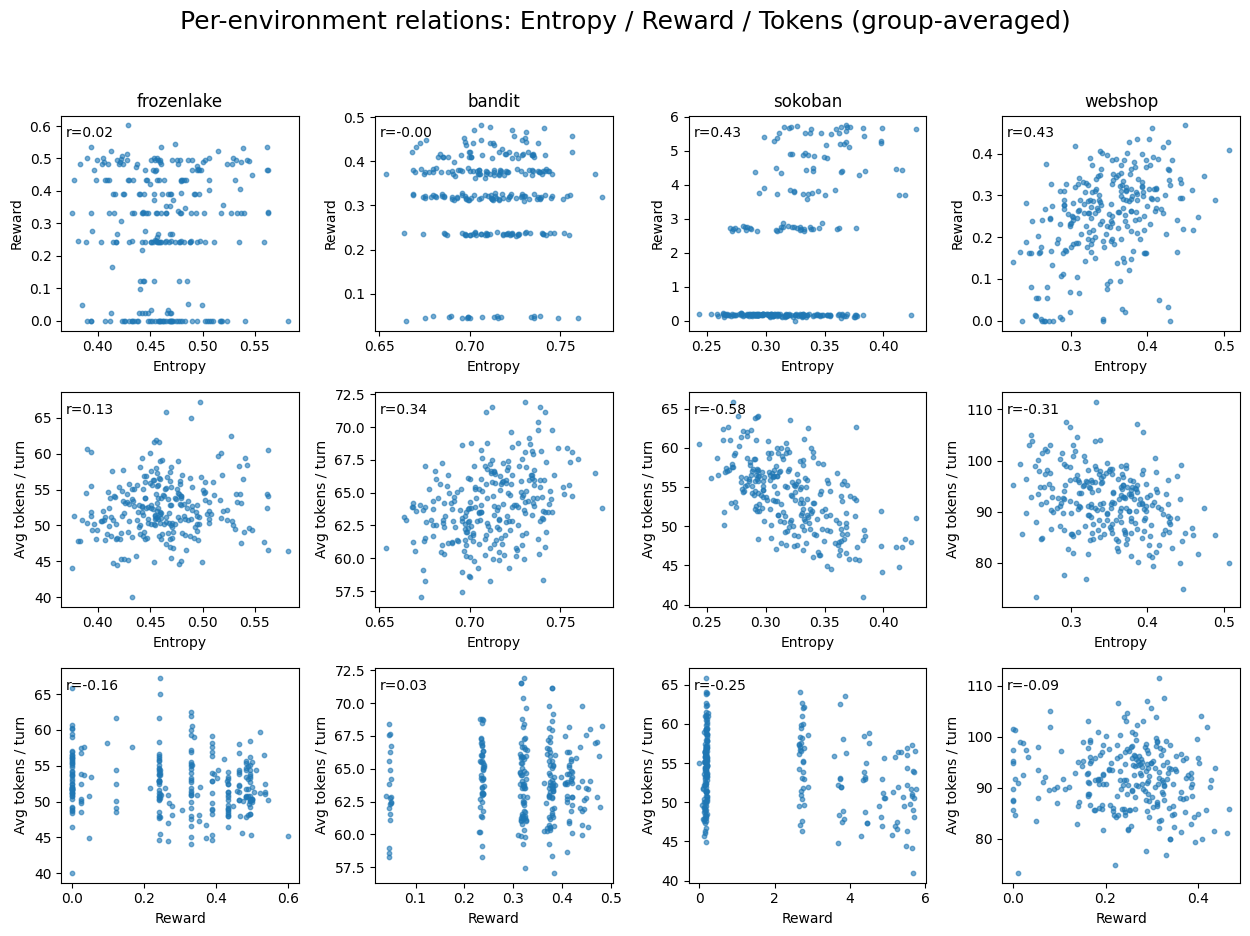

In [75]:
from verl import DataProto
import numpy as np
import matplotlib.pyplot as plt

data_paths = {
    "frozenlake": "/home/aiscuser/RAGEN/results/eval/frozenlake/val_rollouts_20251110_062121.pkl",
    "bandit": "/home/aiscuser/RAGEN/results/eval/bandit/val_rollouts_20251110_062829.pkl",
    "sokoban": "/home/aiscuser/RAGEN/results/eval/sokoban/val_rollouts_20251110_064055.pkl",
    "webshop": "/home/aiscuser/RAGEN/results/eval/webshop/val_rollouts_20251110_120519.pkl",
}

# 假设每个 env 有 n_groups * group_size 条 rollout
n_groups = 256
group_size = 16

fig, axes = plt.subplots(3, 4, figsize=(18*0.7, 14*0.7))
fig.suptitle("Per-environment relations: Entropy / Reward / Tokens (group-averaged)", fontsize=18)

for col, (env, path) in enumerate(data_paths.items()):
    data = DataProto.load_from_disk(path)

    # 取出原始数据
    n_gen = np.asarray(data.non_tensor_batch["n_generated_tokens"])
    n_turns = np.asarray(data.non_tensor_batch["n_turns"])
    ent_all = np.asarray(data.non_tensor_batch["entropys"])
    # 用最后一步 rm_scores 当 reward 信号
    rm_all = np.asarray(data.batch["rm_scores"])[:, -1]

    # 基本长度检查
    expected = n_groups * group_size
    assert rm_all.shape[0] == expected, f"{env}: rm_scores {rm_all.shape[0]} != {expected}"
    assert ent_all.shape[0] == expected, f"{env}: entropys {ent_all.shape[0]} != {expected}"
    assert n_gen.shape[0] == expected and n_turns.shape[0] == expected, f"{env}: token/turn len mismatch"

    # group 内平均
    rm = rm_all.reshape(n_groups, group_size).std(-1)                 # Reward
    ent = ent_all.reshape(n_groups, group_size).mean(-1)               # Entropy
    tok = (n_gen / n_turns).reshape(n_groups, group_size).mean(-1)     # Avg tokens / turn

    # ===== 1) Entropy vs Reward =====
    ax = axes[0, col]
    ax.scatter(ent, rm, s=10, alpha=0.6)
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Reward")
    ax.set_title(env)
    if len(ent) > 1:
        r = np.corrcoef(ent, rm)[0, 1]
        ax.text(0.02, 0.95, f"r={r:.2f}", transform=ax.transAxes,
                ha="left", va="top")

    # ===== 2) Entropy vs Avg tokens / turn =====
    ax = axes[1, col]
    ax.scatter(ent, tok, s=10, alpha=0.6)
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Avg tokens / turn")
    if len(ent) > 1:
        r = np.corrcoef(ent, tok)[0, 1]
        ax.text(0.02, 0.95, f"r={r:.2f}", transform=ax.transAxes,
                ha="left", va="top")

    # ===== 3) Reward vs Avg tokens / turn =====
    ax = axes[2, col]
    ax.scatter(rm, tok, s=10, alpha=0.6)
    ax.set_xlabel("Reward")
    ax.set_ylabel("Avg tokens / turn")
    if len(rm) > 1:
        r = np.corrcoef(rm, tok)[0, 1]
        ax.text(0.02, 0.95, f"r={r:.2f}", transform=ax.transAxes,
                ha="left", va="top")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
